In [1]:
import pandas as pd
from keras.models import Sequential 
from keras.layers import LSTM, Dense 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Step 1: Load the dataset
data = pd.read_csv('crypto_yearly_data.csv')

In [3]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year'], dtype='object')

In [4]:
data.head()

,open,high,low,close,volume,year
0,7195.24,7196.25,7178.20,7180.97,202.942868,2020
1,7180.97,7186.40,7175.47,7178.45,128.242654,2020
2,7178.19,7185.44,7176.23,7179.56,83.487458,2020
3,7179.35,7183.98,7175.46,7177.02,97.141921,2020
4,7176.47,7194.04,7175.71,7190.86,103.520522,2020


In [5]:
data.describe()

,open,high,low,close,volume,year
count,2.672416e+06,2.672416e+06,2.672416e+06,2.672416e+06,2.672416e+06,2.672416e+06
mean,3.195198e+03,3.207895e+03,3.181849e+03,3.195327e+03,1.504969e+07,2.021548e+03
std,9.981067e+03,1.002181e+04,9.938246e+03,9.981333e+03,4.324624e+08,1.102772e+00
min,1.238200e-03,1.379500e-03,1.134500e-03,1.252300e-03,0.000000e+00,2.020000e+03
25%,4.663000e-01,4.688000e-01,4.637000e-01,4.663000e-01,9.472874e+03,2.021000e+03
50%,1.679000e+01,1.689000e+01,1.667725e+01,1.679000e+01,1.068357e+05,2.022000e+03
75%,2.564000e+02,2.579900e+02,2.546400e+02,2.564000e+02,2.948433e+06,2.023000e+03
max,6.871889e+04,6.900000e+04,6.848000e+04,6.871890e+04,3.140397e+11,2.023000e+03


In [6]:
data.shape

(2672416, 6)

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [7]:
# Function to plot a column grouped by year
def plot_grouped_by_year(column_name):
    plt.figure(figsize=(15, 5))
    data.groupby('year')[column_name].mean().plot()
    plt.xlabel("Year")
    plt.ylabel(column_name)
    plt.title(f"{column_name} by Year")
    plt.show()

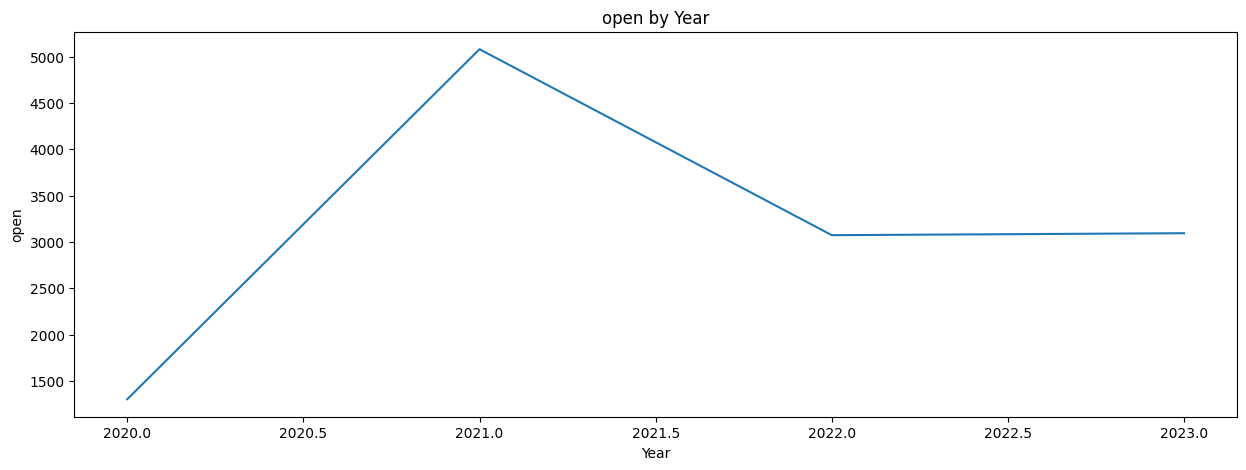

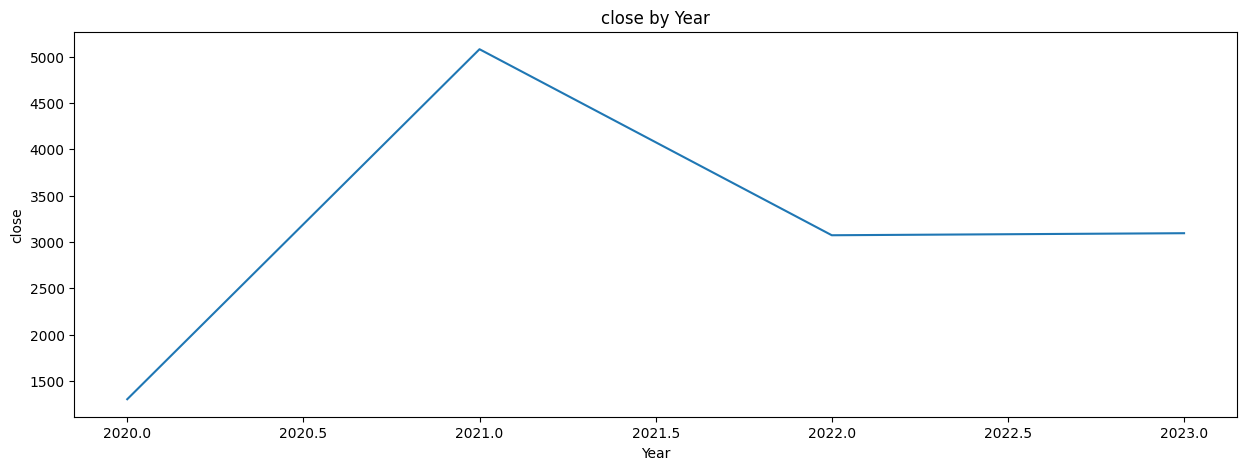

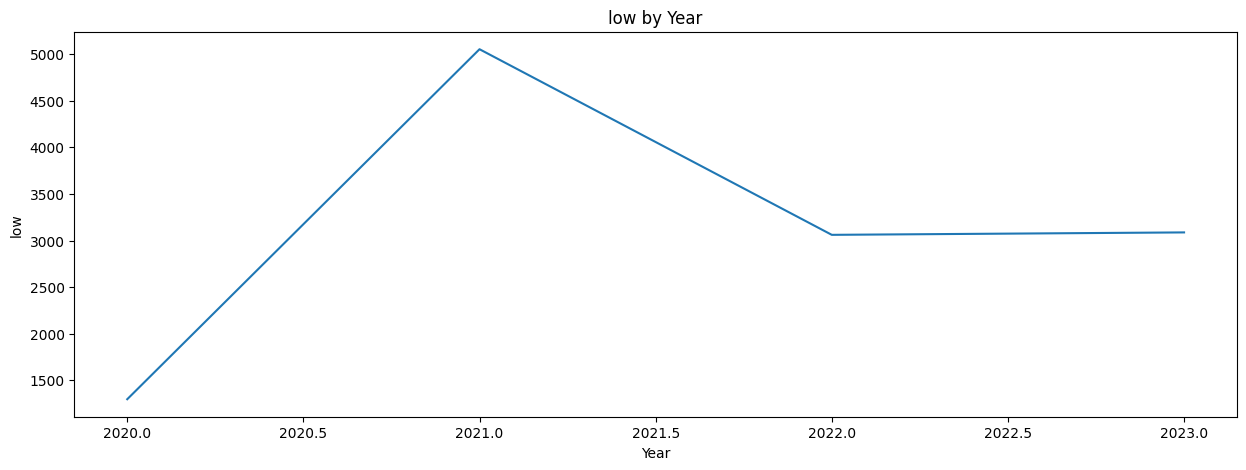

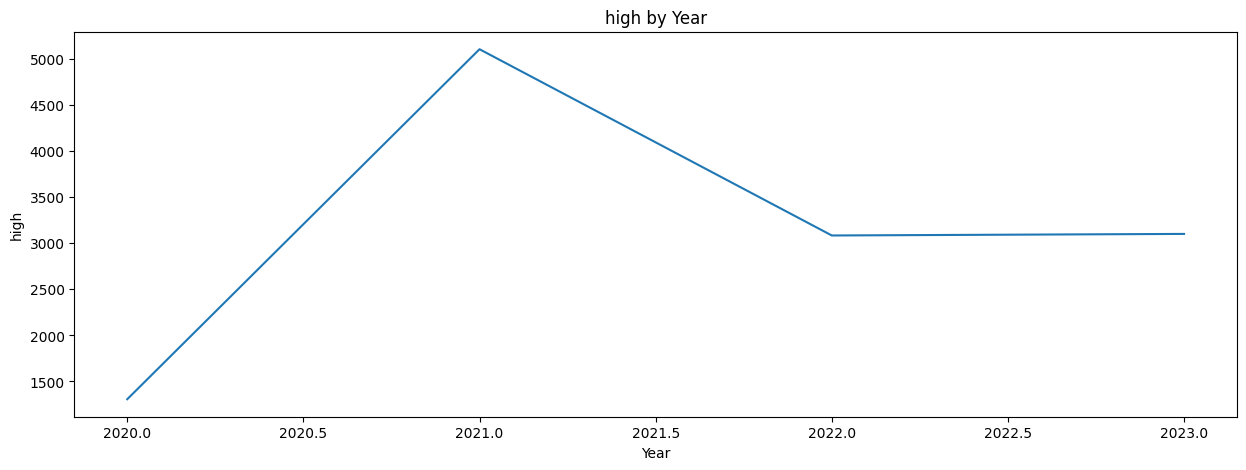

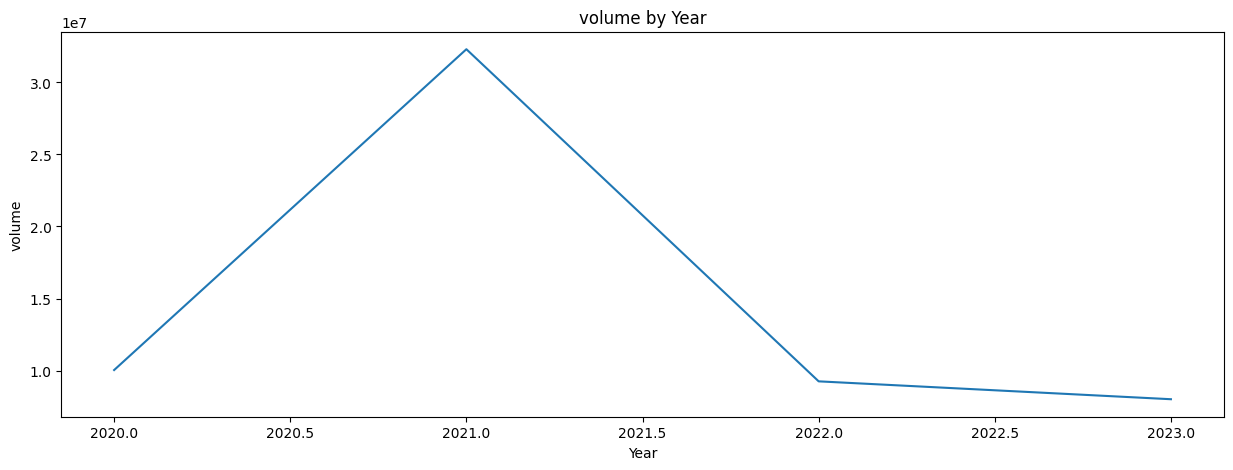

In [8]:
plot_grouped_by_year('open')
plot_grouped_by_year('close')
plot_grouped_by_year('low')
plot_grouped_by_year('high')
plot_grouped_by_year('volume')


In [ ]:
Adj_close_price = data[['close']]

In [ ]:
max(Adj_close_price.values),min(Adj_close_price.values) 

In [ ]:
def prepare_data(data):
    """
    Prepare data for LSTM model by creating sliding windows of features and labels.
    """
    
    # Scale the close prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    data['close_scaled'] = scaler.fit_transform(data[['close']])
    
    # Create features and labels
    features, labels = [], []
    # Adjust loop to ensure valid indexing
    for i in range(len(data) - 100):
        features.append(data['close_scaled'].values[i:i + 100])
        labels.append(data['close_scaled'].values[i + 100])
    
    return np.array(features), np.array(labels), scaler

In [ ]:
def train_lstm_model(features, labels):
    """
    Define, train, and return an LSTM model.
    """
    # Reshape data for LSTM
    features = features.reshape((features.shape[0], features.shape[1], 1))
    
    # Split data into training and testing sets
    train_size = int(len(features) * 0.8)
    X_train, X_test = features[:train_size], features[train_size:]
    y_train, y_test = labels[:train_size], labels[train_size:]

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse') 
    
    # Train the model
    print("Training the LSTM model...")
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Display model summary
    model.summary() 
    
    return model, X_test, y_test


In [ ]:
def evaluate_and_visualize(model, X_test, y_test, scaler):
    """
    Generate predictions, evaluate metrics, and visualize results.
    """
    predictions = model.predict(X_test)
    
    # Inverse scale predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(y_test, predictions.round())  # Round predictions for accuracy calculation
    r2 = r2_score(y_test, predictions)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Accuracy: {accuracy}")
    print(f"R² Score: {r2}")

    # Prepare data for plotting
    plotting_data = pd.DataFrame({
        'original_test_data': y_test.reshape(-1),
        'predictions': predictions.reshape(-1)
    }, index=data.index[100:])

    # Display the first few rows of the plotting data
    print(plotting_data.head())
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(plotting_data['original_test_data'], label='Actual Price')
    plt.plot(plotting_data['predictions'], label='Predicted Price')
    plt.legend()
    plt.title('Actual vs Predicted Prices')
    plt.show()


In [ ]:
# Save the model
def save_model(model, file_path="lstm_model.keras"):
    """
    Save the trained model to a file.
    """
    model.save(file_path)
    print(f"Model saved to {file_path}.")


In [ ]:
model_file = "lstm_model.keras"

if not data.empty:
    # Prepare data for AI model
    features, labels, scaler = prepare_data(data)

    # Train LSTM model
    model, X_test, y_test = train_lstm_model(features, labels)
    

    # Save the model
    save_model(model, file_path=model_file)

    # Evaluate and visualize results
    evaluate_and_visualize(model, X_test, y_test, scaler)
else:
    print("Data not found or empty. Exiting...")
